In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import sklearn as sk
from sklearn.pipeline import Pipeline
from diffprivlib import models

In [ ]:
df = pd.read_csv('framingham.csv')

In [ ]:
df.head()

male  age  education  currentSmoker  ...    BMI  heartRate  glucose  TenYearCHD
0     1   39        4.0              0  ...  26.97       80.0     77.0           0
1     0   46        2.0              0  ...  28.73       95.0     76.0           0
2     1   48        1.0              1  ...  25.34       75.0     70.0           0
3     0   61        3.0              1  ...  28.58       65.0    103.0           1
4     0   46        3.0              1  ...  23.10       85.0     85.0           0

[5 rows x 16 columns]

In [ ]:
df.isna().sum()

male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
TenYearCHD           0
dtype: int64

In [ ]:
df['education'].fillna(value = df['education'].std(), inplace = True)
df['cigsPerDay'].fillna(value = df['cigsPerDay'].std(), inplace = True)
df['BPMeds'].fillna(value = df['BPMeds'].std(), inplace = True)
df['totChol'].fillna(value = df['totChol'].std(), inplace = True)
df['BMI'].fillna(value = df['BMI'].median(), inplace = True)
df['heartRate'].fillna(value = df['heartRate'].std(), inplace = True)
df['glucose'].fillna(value = df['glucose'].std(), inplace = True)

In [ ]:
df.isna().sum() #All missing values have been taken care of

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

In [ ]:
df.head()

male  age  education  currentSmoker  ...    BMI  heartRate  glucose  TenYearCHD
0     1   39        4.0              0  ...  26.97       80.0     77.0           0
1     0   46        2.0              0  ...  28.73       95.0     76.0           0
2     1   48        1.0              1  ...  25.34       75.0     70.0           0
3     0   61        3.0              1  ...  28.58       65.0    103.0           1
4     0   46        3.0              1  ...  23.10       85.0     85.0           0

[5 rows x 16 columns]

In [ ]:
df.describe()

male          age  ...      glucose   TenYearCHD
count  4238.000000  4238.000000  ...  4238.000000  4238.000000
mean      0.429212    49.584946  ...    76.656083     0.151958
std       0.495022     8.572160  ...    28.309504     0.359023
min       0.000000    32.000000  ...    23.959998     0.000000
25%       0.000000    42.000000  ...    68.000000     0.000000
50%       0.000000    49.000000  ...    77.000000     0.000000
75%       1.000000    56.000000  ...    85.000000     0.000000
max       1.000000    70.000000  ...   394.000000     1.000000

[8 rows x 16 columns]

In [ ]:
#sns.distplot(df['currentSmoker'], kde = False)

In [ ]:
#sns.pairplot(df)

In [ ]:
#sns.boxplot(x = 'currentSmoker', y = 'totChol', data = df, hue = 'male')

In [ ]:
#subdf1 = df[['age', 'currentSmoker']]

In [ ]:
#subdf1.head()

In [ ]:
#subdf1_corr = subdf1.corr()

In [ ]:
#sns.heatmap(data = subdf1_corr, annot = True, cmap = 'coolwarm')

In [ ]:
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30)

In [ ]:
pipe = Pipeline([
    ('scaler', sk.preprocessing.StandardScaler()),
    ('pca', sk.decomposition.PCA(2)),
    ('lr', sk.linear_model.LogisticRegression(solver="lbfgs"))
])

In [ ]:
pipe.fit(X_train, y_train)
baseline = pipe.score(X_test, y_test)
print("Non-private test accuracy: %.2f%%" % (baseline * 100))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy')
model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=10)

In [ ]:
y_pred = model.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
cm_plot_labels = ['No Heart Disease','Heart Disease']

In [ ]:
cm = confusion_matrix(y_true=y_test, y_pred=y_pred)

Confusion matrix, without normalization
[[1060   11]
 [ 191   10]]


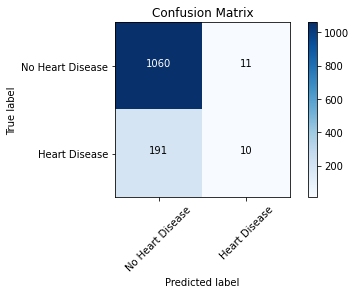

In [ ]:
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
accuracy = (cm[0][0]+cm[1][1])/(cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])
print('Accuracy is:',accuracy * 100)

Accuracy is: 84.11949685534591
